In [35]:
# Import libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import operator
import math
import random
import numpy as np
import pandas as pd
from deap import algorithms, base, creator, gp, tools
from sklearn.metrics import mean_squared_error
from sklearn.utils import check_random_state
from gplearn.genetic import SymbolicRegressor

In [36]:
# Load the simulation results
file_path = 'simulation_results.csv'
sim_results = pd.read_csv(file_path)

In [37]:
sim_results = sim_results.loc[:, ~sim_results.columns.str.contains('^Unnamed')]
sim_results.head()

,n,m,mux,muy,sigmax,sigmay,prob,theoertical
0,2,2,0.5,0.0,0.5,0.5,0.000000,0.841345
1,3,2,0.5,0.0,0.5,0.5,0.050000,0.863339
2,4,2,0.5,0.0,0.5,0.5,0.025000,0.875893
3,5,2,0.5,0.0,0.5,0.5,0.021429,0.884001
4,6,2,0.5,0.0,0.5,0.5,0.068750,0.889664


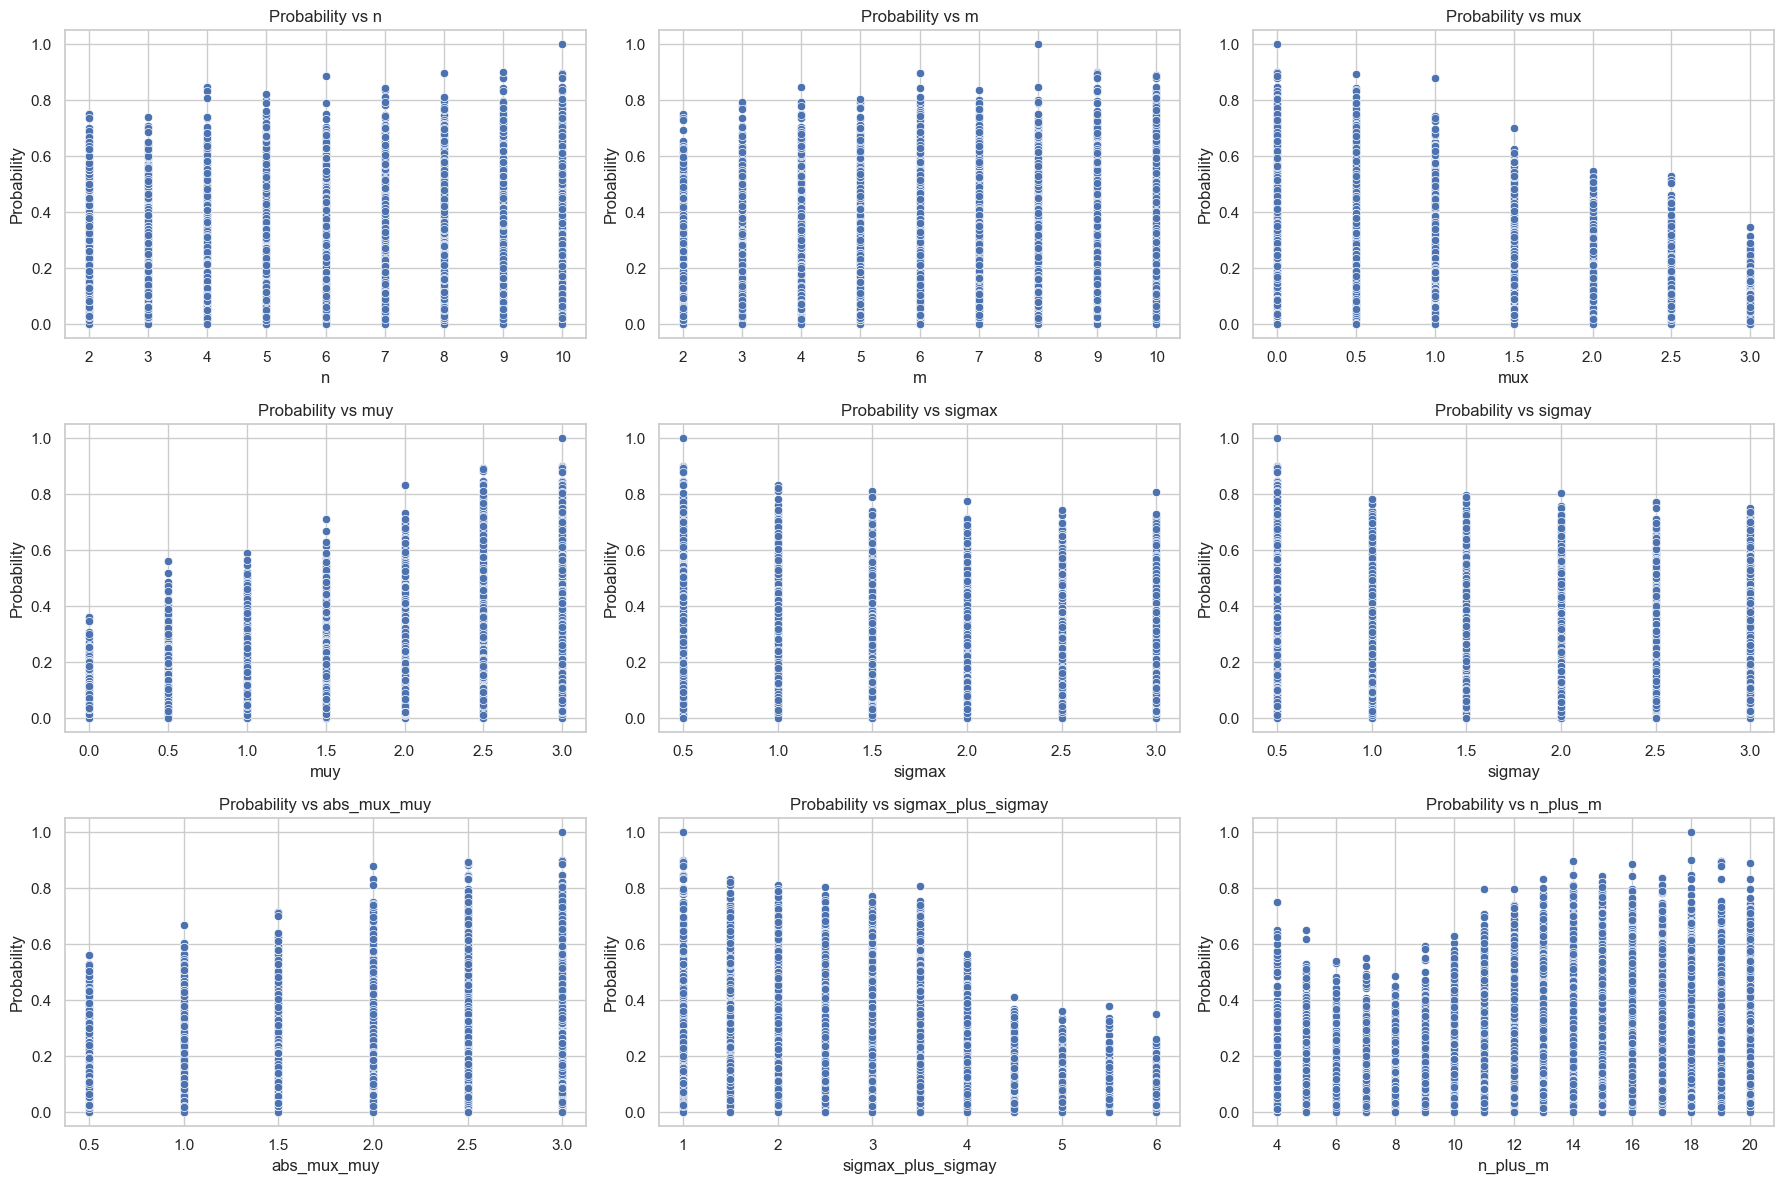

In [38]:
# Derived parameters
sim_results['abs_mux_muy'] = abs(sim_results['mux'] - sim_results['muy'])
sim_results['sigmax_plus_sigmay'] = sim_results['sigmax'] + sim_results['sigmay']
sim_results['n_plus_m'] = sim_results['n'] + sim_results['m']

# Plot settings
sns.set(style="whitegrid")

# List of parameters
individual_parameters = ['n', 'm', 'mux', 'muy', 'sigmax', 'sigmay']
derived_parameters = ['abs_mux_muy', 'sigmax_plus_sigmay', 'n_plus_m']

# Combine all parameters
all_parameters = individual_parameters + derived_parameters

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))

# Plot each parameter
for ax, param in zip(axes.flat, all_parameters):
    sns.scatterplot(x=sim_results[param], y=sim_results['prob'], ax=ax)
    ax.set_title(f'Probability vs {param}')
    ax.set_xlabel(param)
    ax.set_ylabel('Probability')
    ax.grid(True)

plt.tight_layout()
plt.show()

In [39]:
# Calculate the derived parameter |mux - muy| / sqrt(sigmax^2 / n + sigmay^2 / m)
def calculate_derived_param(row):
    try:
        value = abs(row['mux'] - row['muy']) / ((row['sigmax']**2 / row['n'] + row['sigmay']**2 / row['m'])**0.5)
        if value == float('inf'):
            return 10
        return value
    except ZeroDivisionError:
        return 10

sim_results['derived_param'] = sim_results.apply(calculate_derived_param, axis=1)

In [40]:
# Calculate the derived parameter |mux - muy| / sqrt(sigmax^2 / n + sigmay^2 / m)
def calculate_derived_param(row):
    try:
        value = abs(row['mux'] - row['muy']) / ((row['sigmax']**2 / row['n'] + row['sigmay']**2 / row['m'])**0.5)
        if value == float('inf'):
            return 10
        return value
    except ZeroDivisionError:
        return 10

sim_results['theoretical'] = sim_results.apply(calculate_derived_param, axis=1)

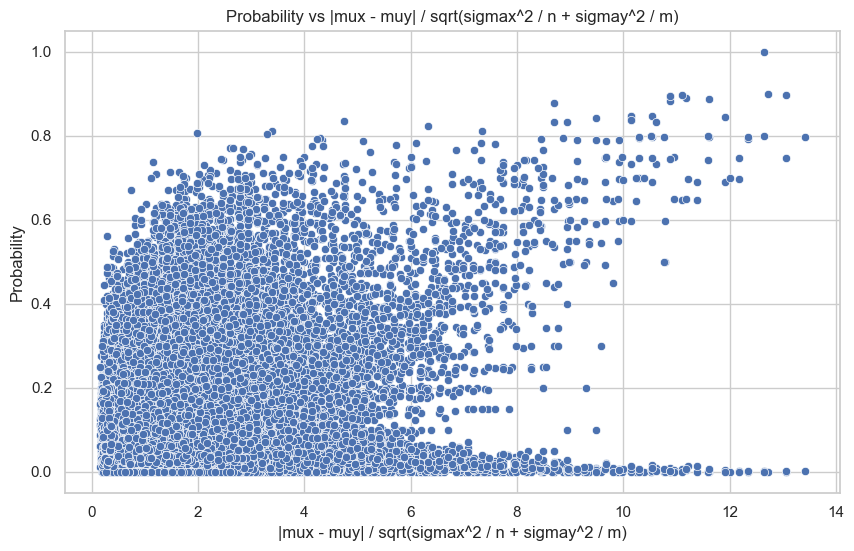

In [41]:
# Plot the derived parameter against the probability
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sim_results['derived_param'], y=sim_results['prob'])
plt.title('Probability vs |mux - muy| / sqrt(sigmax^2 / n + sigmay^2 / m)')
plt.xlabel('|mux - muy| / sqrt(sigmax^2 / n + sigmay^2 / m)')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

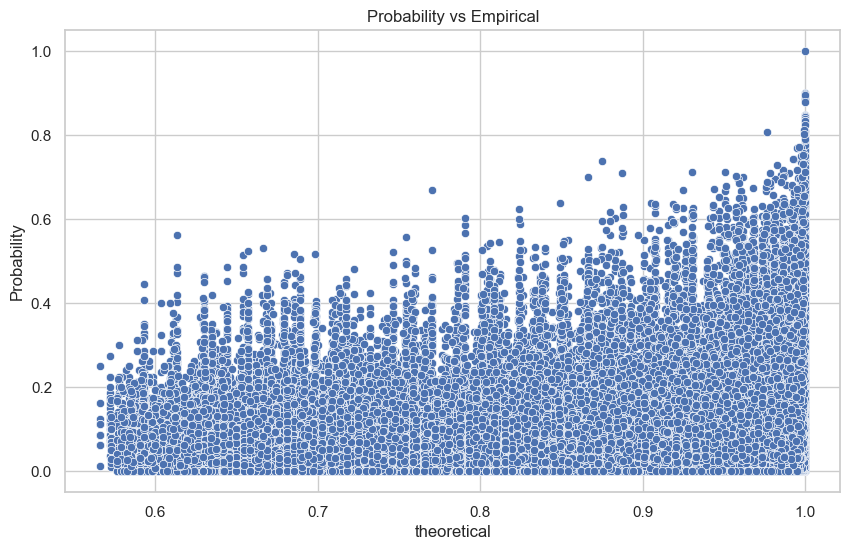

In [44]:
# Plot the derived parameter against the probability
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sim_results['theoertical'], y=sim_results['prob'])
plt.title('Probability vs Empirical')
plt.xlabel('theoretical')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

In [42]:
# Find the rows with the 10 highest values of the derived parameter
top_10_rows = sim_results.nlargest(10, 'derived_param')

# Display the top 10 rows
top_10_rows

,n,m,mux,muy,sigmax,sigmay,prob,theoertical,abs_mux_muy,sigmax_plus_sigmay,n_plus_m,derived_param,theoretical
485,10,10,3.0,0.0,0.5,0.5,0.002500,1.0,3.0,1.0,20,13.416408,13.416408
2996,10,10,0.0,3.0,0.5,0.5,0.797500,1.0,3.0,1.0,20,13.416408,13.416408
476,10,9,3.0,0.0,0.5,0.5,0.000000,1.0,3.0,1.0,19,13.058573,13.058573
484,9,10,3.0,0.0,0.5,0.5,0.002632,1.0,3.0,1.0,19,13.058573,13.058573
2987,10,9,0.0,3.0,0.5,0.5,0.897368,1.0,3.0,1.0,19,13.058573,13.058573
2995,9,10,0.0,3.0,0.5,0.5,0.747368,1.0,3.0,1.0,19,13.058573,13.058573
475,9,9,3.0,0.0,0.5,0.5,0.000000,1.0,3.0,1.0,18,12.727922,12.727922
2986,9,9,0.0,3.0,0.5,0.5,0.900000,1.0,3.0,1.0,18,12.727922,12.727922
467,10,8,3.0,0.0,0.5,0.5,0.002778,1.0,3.0,1.0,18,12.649111,12.649111
483,8,10,3.0,0.0,0.5,0.5,0.000000,1.0,3.0,1.0,18,12.649111,12.649111


    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.88          3.92007        2        0.0692565              N/A      5.60m
   1     8.98           1.0562        4        0.0615625              N/A      3.81m
   2     5.77         0.928815        4        0.0615625              N/A      3.29m
   3     3.51         0.539423        5        0.0615585              N/A      3.26m
   4     3.21         0.263195        8        0.0614828              N/A      4.28m
   5     3.74         0.356776        4        0.0615625              N/A      4.00m
   6     3.13         0.303349        4        0.0615625              N/A      3.20m
   7     2.02        0.0923242        4        0.0615625              N/A      2.83m
   8     2.03        0.0880246        2        0.0618935              N/A  

  94     2.04          0.15793        2        0.0618935              N/A      1.92m
  95     2.02        0.0915828        2        0.0618935              N/A      2.10m
  96     2.02        0.0916793        2        0.0618935              N/A      1.88m
  97     2.01        0.0842565        2        0.0618935              N/A      1.83m
  98     2.02         0.103804        3        0.0618935              N/A      1.73m
  99     2.06        0.0820617        2        0.0618935              N/A      2.74m
 100     2.03        0.0984731        2        0.0618935              N/A      1.79m
 101     2.02        0.0864877        2        0.0618935              N/A      1.70m
 102     2.02         0.132715        2        0.0618935              N/A      1.95m
 103     2.03        0.0901235        2        0.0618935              N/A      1.82m
 104     1.99        0.0866197        2        0.0618935              N/A      1.62m
 105     2.01        0.0893406        2        0.0618935         

 191     2.02        0.0825415        2        0.0618935              N/A     10.51s
 192     2.03         0.120154        2        0.0618935              N/A      8.58s
 193     2.03         0.103736        2        0.0618935              N/A      7.22s
 194     2.03         0.129313        2        0.0618935              N/A      5.62s
 195     2.04        0.0943091        2        0.0618935              N/A      4.76s
 196     2.03        0.0826369        2        0.0618935              N/A      3.56s
 197     2.02         0.138734        2        0.0618935              N/A      2.47s
 198     2.02        0.0804717        3        0.0618935              N/A      1.20s
 199     2.03          0.10016        2        0.0618935              N/A      0.00s
Best program:
abs(-0.080)


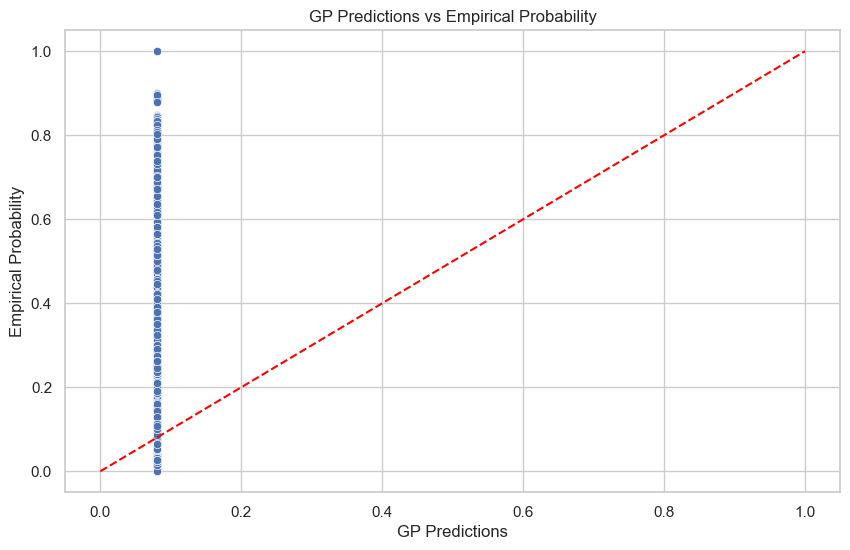

   n  m  mux  muy  sigmax  sigmay      prob  theoertical  abs_mux_muy  \
0  2  2  0.5  0.0     0.5     0.5  0.000000     0.841345          0.5   
1  3  2  0.5  0.0     0.5     0.5  0.050000     0.863339          0.5   
2  4  2  0.5  0.0     0.5     0.5  0.025000     0.875893          0.5   
3  5  2  0.5  0.0     0.5     0.5  0.021429     0.884001          0.5   
4  6  2  0.5  0.0     0.5     0.5  0.068750     0.889664          0.5   

   sigmax_plus_sigmay  n_plus_m  derived_param  theoretical  gp_predictions  
0                 1.0         4       1.000000     1.000000        0.079695  
1                 1.0         5       1.095445     1.095445        0.079695  
2                 1.0         6       1.154701     1.154701        0.079695  
3                 1.0         7       1.195229     1.195229        0.079695  
4                 1.0         8       1.224745     1.224745        0.079695  


In [43]:
# Prepare the data for gplearn
X = sim_results[['n', 'm', 'mux', 'muy', 'sigmax', 'sigmay']]
y = sim_results['prob']

# Define the symbolic regressor model
function_set = ['add', 'sub', 'mul', 'div', 'sin', 'cos', 'sqrt', 'log', 'abs']
gp = SymbolicRegressor(function_set = function_set, 
                       generations = 200,  
                       population_size = 2000, 
                       tournament_size = 20,  
                       stopping_criteria = 0.00001,  
                       n_jobs = -1, 
                       verbose = 1, 
                       random_state = 42)

# Fit the model
gp.fit(X, y)

# Make predictions
y_pred = gp.predict(X)

# Add predictions to the dataframe
sim_results['gp_predictions'] = y_pred

# Print the best program found
print(f"Best program:\n{gp._program}")

# Plot the predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sim_results['gp_predictions'], y=sim_results['prob'])
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line of perfect agreement
plt.title('GP Predictions vs Empirical Probability')
plt.xlabel('GP Predictions')
plt.ylabel('Empirical Probability')
plt.grid(True)
plt.show()

# Display the updated dataframe
print(sim_results.head())

In [45]:
def adjust_theoretical_prob(sim_results, theoretical_col, empirical_col):
    """
    Adjust the theoretical probability column based on the empirical probability column.
    
    Parameters:
    - sim_results: DataFrame containing the simulation results.
    - theoretical_col: Name of the column containing theoretical probabilities.
    - empirical_col: Name of the column containing empirical probabilities.
    
    The function modifies the DataFrame in place.
    """
    def adjust_prob(theoretical_value, empirical_value):
        if abs(theoretical_value - empirical_value) > abs(1 - theoretical_value - empirical_value):
            return 1 - theoretical_value
        return theoretical_value

    sim_results[theoretical_col] = sim_results.apply(
        lambda row: adjust_prob(row[theoretical_col], row[empirical_col]), axis=1
    )

# Example usage
# Assuming 'sim_results' is the DataFrame and it contains columns 'theoretical_prob' and 'prob'

# Adjust the theoretical probability column
adjust_theoretical_prob(sim_results, 'theoertical', 'prob')

In [ ]:
sim_results.head()

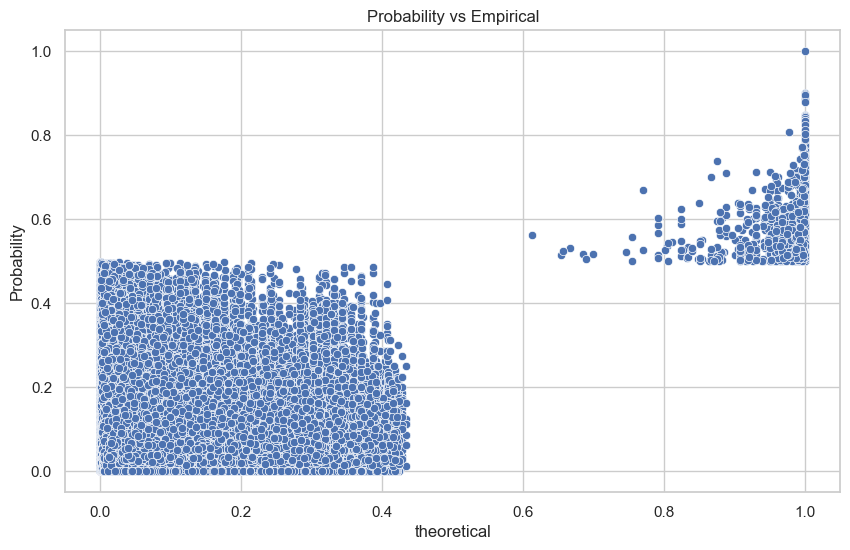

In [46]:
# Plot the derived parameter against the probability
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sim_results['theoertical'], y=sim_results['prob'])
plt.title('Probability vs Empirical')
plt.xlabel('theoretical')
plt.ylabel('Probability')
plt.grid(True)
plt.show()

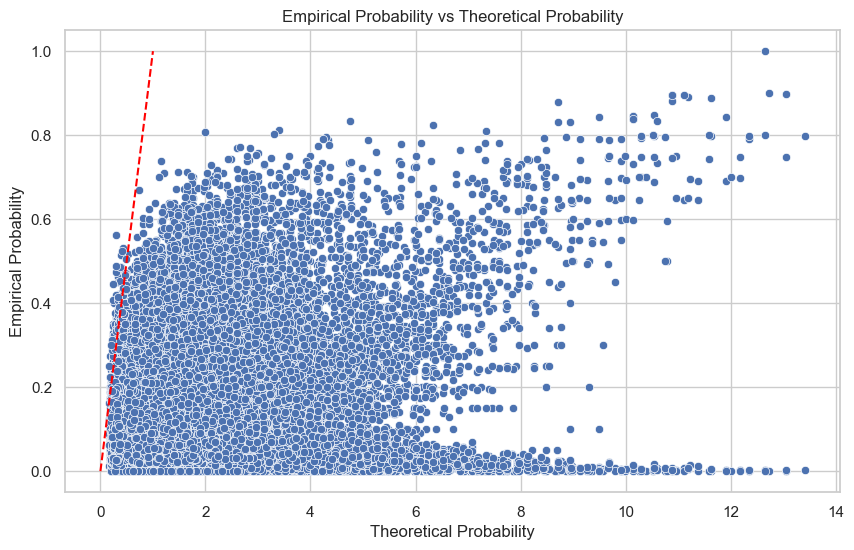

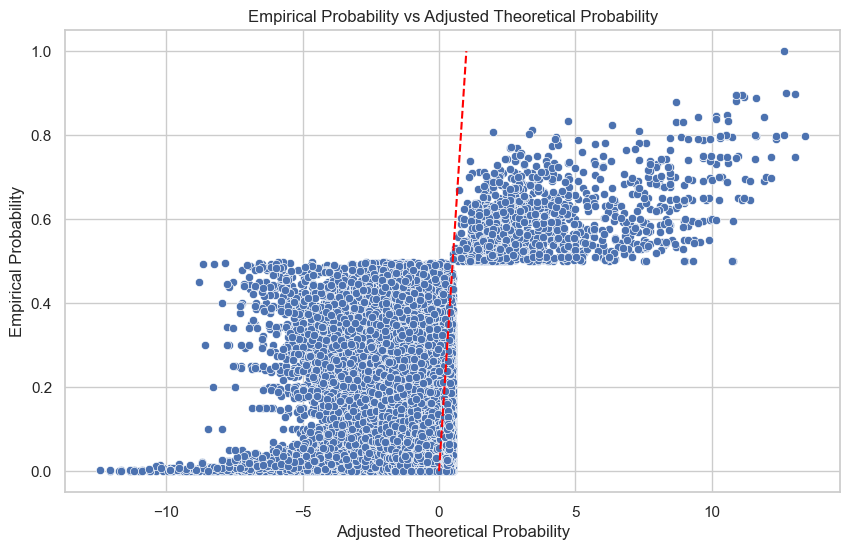

In [47]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sim_results['theoretical'], y=sim_results['prob'])
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line of perfect agreement
plt.title('Empirical Probability vs Theoretical Probability')
plt.xlabel('Theoretical Probability')
plt.ylabel('Empirical Probability')
plt.grid(True)
plt.show()

# Define the function to adjust the theoretical probabilities
def adjust_theoretical_prob(sim_results, theoretical_col, empirical_col):
    """
    Adjust the theoretical probability column based on the empirical probability column.
    
    Parameters:
    - sim_results: DataFrame containing the simulation results.
    - theoretical_col: Name of the column containing theoretical probabilities.
    - empirical_col: Name of the column containing empirical probabilities.
    
    The function modifies the DataFrame in place.
    """
    def adjust_prob(theoretical_value, empirical_value):
        # Compare theoretical value and its complement to the empirical value
        if abs(theoretical_value - empirical_value) > abs(1 - theoretical_value - empirical_value):
            return 1 - theoretical_value
        return theoretical_value

    sim_results[theoretical_col] = sim_results.apply(
        lambda row: adjust_prob(row[theoretical_col], row[empirical_col]), axis=1
    )

# Apply the adjustment function
adjust_theoretical_prob(sim_results, 'theoretical', 'prob')

# Plot empirical probabilities vs. adjusted theoretical probabilities
plt.figure(figsize=(10, 6))
sns.scatterplot(x=sim_results['theoretical'], y=sim_results['prob'])
plt.plot([0, 1], [0, 1], color='red', linestyle='--')  # Line of perfect agreement
plt.title('Empirical Probability vs Adjusted Theoretical Probability')
plt.xlabel('Adjusted Theoretical Probability')
plt.ylabel('Empirical Probability')
plt.grid(True)
plt.show()

In [62]:
import numpy as np
from scipy.stats import norm, invgamma

# Function to calculate the posterior mean
def posterior_mean(data, mu_0, tau_0, sigma_sq):
    n = len(data)
    mean_data = np.mean(data)
    return (tau_0**2 * n * mean_data + sigma_sq * mu_0) / (n * tau_0**2 + sigma_sq)

# Function to calculate the posterior variance
def posterior_variance(n, tau_0, sigma_sq):
    return (sigma_sq * tau_0**2) / (n * tau_0**2 + sigma_sq)

# Function to calculate the probability of correct classification
def probability_correct_classification(X, Y, mu_0, tau_0, alpha_0, beta_0):
    # Estimate the sample variances
    sigma_x_sq = np.var(X, ddof=1)
    sigma_y_sq = np.var(Y, ddof=1)
    
    # Calculate the posterior means
    mu_x_hat = posterior_mean(X, mu_0, tau_0, sigma_x_sq)
    mu_y_hat = posterior_mean(Y, mu_0, tau_0, sigma_y_sq)
    
    # Calculate the posterior variances
    sigma_x_hat_sq = posterior_variance(len(X), tau_0, sigma_x_sq)
    sigma_y_hat_sq = posterior_variance(len(Y), tau_0, sigma_y_sq)
    
    # Calculate the discriminant function d'
    d_prime = (mu_x_hat - mu_y_hat) / np.sqrt(sigma_x_hat_sq / len(X) + sigma_y_hat_sq / len(Y))
    
    # Calculate the probability using the normal CDF
    prob = norm.cdf(d_prime)
    
    return prob

# Example usage
# Sample data
X = np.random.normal(1, 2, 3)  # Sample from N(0, 1) with n=30
Y = np.random.normal(5, 1, 3)  # Sample from N(1, 1) with m=30

# Parameters for the priors
mu_0 = np.mean(np.concatenate((X, Y)))  # Using the combined mean as the prior mean
tau_0 = 1000  # Setting a large value for prior variance to make it less informative
alpha_0 = 2  # Example prior shape parameter for variance
beta_0 = 2  # Example prior scale parameter for variance

# Calculate the probability of correct classification
prob = probability_correct_classification(X, Y, mu_0, tau_0, alpha_0, beta_0)
print(f'Probability of correctly classifying the point: {1 - prob}')

Probability of correctly classifying the point: 0.9999999922028668
